In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import swifter
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
cd ..

/Users/rabarry/Documents/Insight/NYC data/SafeEats


In [4]:
cd data/processed

/Users/rabarry/Documents/Insight/NYC data/SafeEats/data/processed


# Prepare data for models

#### Load in the data

In [93]:
data = pd.read_csv('HD_NY311_Hoods.csv')

#### Code data labels <br>
Good = 0 critical flags at last inspection <br>
Bad = 1 or more critical flags at last inspection

In [94]:
data['is_good_lastInsp'] = np.where(data['Last_Insp_Num_CriticialFlags']>0,0,1)
print(data['is_good_lastInsp'].value_counts())

0    21366
1     4281
Name: is_good_lastInsp, dtype: int64


#### Re-code Cuisine Type <br>
Went from 84 types to 6

In [95]:
conditions = [
    (data['CUISINE DESCRIPTION'] == 'American') |  (data['CUISINE DESCRIPTION'] == 'Hamburgers') | (data['CUISINE DESCRIPTION'] == 'Steak') | (data['CUISINE DESCRIPTION'] == 'Soul Food') | (data['CUISINE DESCRIPTION'] == 'Barbecue') | (data['CUISINE DESCRIPTION'] == 'Hotdogs/Pretzels') | (data['CUISINE DESCRIPTION'] == 'Hotdogs') | (data['CUISINE DESCRIPTION'] == 'Californian') | (data['CUISINE DESCRIPTION'] == 'Southwestern') | (data['CUISINE DESCRIPTION'] == 'Chicken'),
    (data['CUISINE DESCRIPTION'] == 'Chinese') | (data['CUISINE DESCRIPTION'] == 'Japanese') | (data['CUISINE DESCRIPTION'] == 'Asian') | (data['CUISINE DESCRIPTION'] == 'Thai') | (data['CUISINE DESCRIPTION'] == 'Korean') | (data['CUISINE DESCRIPTION'] == 'Vietnamese/Cambodian/Malaysia') | (data['CUISINE DESCRIPTION'] == 'Chinese/Japanese') | (data['CUISINE DESCRIPTION'] == 'Filipino') | (data['CUISINE DESCRIPTION'] == 'Indonesian'), 
    (data['CUISINE DESCRIPTION'] == 'Café/Coffee/Tea') | (data['CUISINE DESCRIPTION'] == 'Bakery') | (data['CUISINE DESCRIPTION'] == 'Donuts') | (data['CUISINE DESCRIPTION'] == 'Juice, Smoothies, Fruit Salads') | (data['CUISINE DESCRIPTION'] == 'Ice Cream, Gelato, Yogurt, Ices') | (data['CUISINE DESCRIPTION'] == 'Bottled beverages, including water, sodas, juices, etc. ') | (data['CUISINE DESCRIPTION'] == 'Pancakes/Waffles')| (data['CUISINE DESCRIPTION'] == 'Nuts/Confectionary'),
    (data['CUISINE DESCRIPTION'] == 'Pizza') | (data['CUISINE DESCRIPTION'] == 'Italian') | (data['CUISINE DESCRIPTION'] == 'Pizza/Italian'),
    (data['CUISINE DESCRIPTION'] == 'Mexican') | (data['CUISINE DESCRIPTION'] == 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)') | (data['CUISINE DESCRIPTION'] == 'Spanish') | (data['CUISINE DESCRIPTION'] == 'Tex-Mex') | (data['CUISINE DESCRIPTION'] == 'Peruvian') | (data['CUISINE DESCRIPTION'] == 'Tapas') | (data['CUISINE DESCRIPTION'] == 'Chilean')      
]
choices = ['American', 'Asian', 'Cafe/Dessert', 'Italian', 'Latin']
data['Cuisine_Reduced'] = np.select(conditions, choices, default='Other')
print(data['Cuisine_Reduced'].value_counts())
data['Cuisine_Reduced'].isnull().sum(axis = 0);

American        6948
Other           5020
Asian           4466
Cafe/Dessert    3881
Latin           2700
Italian         2632
Name: Cuisine_Reduced, dtype: int64


#### Recode all other categorical variables

In [96]:
data['Second_Last_Insp_Type_CAT']=data['Second_Last_Insp_Type'].astype('category')
data['Second_Last_Insp_Type_CAT'] = data['Second_Last_Insp_Type_CAT'].cat.codes
data['Second_Last_Insp_Num_CriticialFlags_CAT']=data['Second_Last_Insp_Num_CriticialFlags'].astype('category')
data['BORO_CAT']=data['BORO'].astype('category')
data['BORO_CAT'] = data['BORO_CAT'].cat.codes
data['num_years_active_CAT']=data['num_years_active'].astype('category')
data['Cuisine_CAT']=data['Cuisine_Reduced'].astype('category')
data['Cuisine_CAT'] = data['Cuisine_CAT'].cat.codes
data['is_good_lastInsp']= data['is_good_lastInsp'].astype('category')

#### Remove restaurants that don't have a previous inspection

In [97]:
len(data);
data = data[data['Second_Last_Insp_Type'].notnull()]
len(data);

#### Format data types 

In [98]:
data['Median household income (2018$)'] = data['Median household income (2018$)'].str[1:]
data['Poverty rate'] = data['Poverty rate'].str[:-1]
data['Public housing (% of rental units)'] = data['Public housing (% of rental units)'].str[:-1]

data = data.swifter.apply(lambda x: x.str.strip() if x.dtype =='object' else x)

data = data.swifter.apply(lambda x: x.str.replace(',','') if x.dtype =='object' else x)

data['Median household income (2018$)'] = data['Median household income (2018$)'].astype('float64')

data['Population'] = data['Population'].astype('float64')
data['Poverty rate'] = data['Poverty rate'].astype('float64')
data['Public housing (% of rental units)'] = data['Public housing (% of rental units)'].astype('float64')

#### Specify the columns that will be included in the model
Also, remove any rows containing NaN

In [99]:
data4model = data[['Insp_Date_Diff', 'ny311_number_of_complaints_12mo',
       'Second_Last_Insp_Type_CAT', 'Second_Last_Insp_Num_CriticialFlags_CAT',
       'BORO_CAT', 'num_years_active_CAT', 'Cuisine_CAT', 'Income diversity ratio', 'Median household income (2018$)',
       'Population', 'Population density (1,000 persons per square mile)',
       'Poverty rate', 'Public housing (% of rental units)',
       'Racial diversity index', 'Serious crime rate (per 1,000 residents)',
       'Serious housing code violations (per 1,000 privately owned rental units)', 'is_good_lastInsp']]
data4model = data4model.dropna()
data4model.shape

(23381, 17)

#### Specify the labels (y data)

In [100]:
Good_y = data4model['is_good_lastInsp']
Good_y = np.ravel(Good_y)
Good_y.shape

(23381,)

#### Specify the features (x data)

In [101]:
Good_x = data4model[['Insp_Date_Diff', 'ny311_number_of_complaints_12mo',
       'Second_Last_Insp_Type_CAT', 'Second_Last_Insp_Num_CriticialFlags_CAT',
       'BORO_CAT', 'num_years_active_CAT', 'Cuisine_CAT', 'Income diversity ratio', 'Median household income (2018$)',
       'Population', 'Population density (1,000 persons per square mile)',
       'Poverty rate', 'Public housing (% of rental units)',
       'Racial diversity index', 'Serious crime rate (per 1,000 residents)',
       'Serious housing code violations (per 1,000 privately owned rental units)']]
Good_x.shape
Good_x.dtypes

(23381, 16)

Insp_Date_Diff                                                               float64
ny311_number_of_complaints_12mo                                              float64
Second_Last_Insp_Type_CAT                                                       int8
Second_Last_Insp_Num_CriticialFlags_CAT                                     category
BORO_CAT                                                                        int8
num_years_active_CAT                                                        category
Cuisine_CAT                                                                     int8
Income diversity ratio                                                       float64
Median household income (2018$)                                              float64
Population                                                                   float64
Population density (1,000 persons per square mile)                           float64
Poverty rate                                                     

#### Plot correlation matrix

<Figure size 432x288 with 0 Axes>

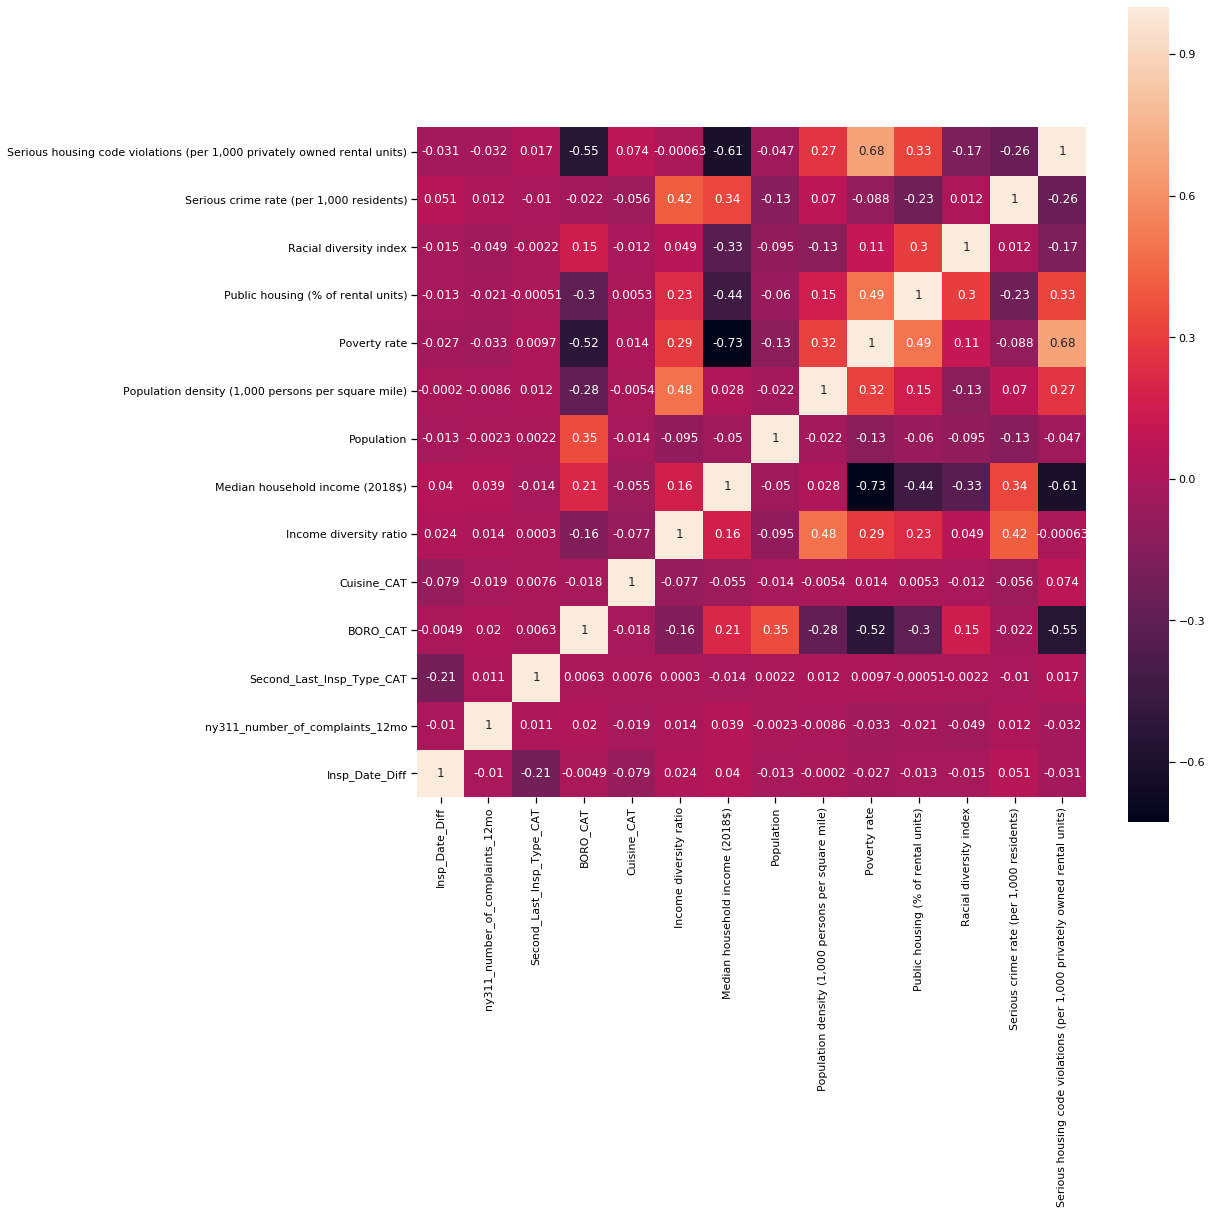

In [102]:
sns.set_context("notebook");
plt.tight_layout();
corr=Good_x.corr();
plt.figure(figsize=(15,15));
g = sns.heatmap(corr, cbar=True, annot=True, square=True)
g.set_ylim(0,16);
#plt.savefig('Correlation_Matrix.png')

#### Train/Test split 75/25

In [103]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Good_x, Good_y, test_size=0.25, random_state=123, shuffle = True)

In [104]:
print(f'Size of training features: {x_train.shape}')
print(f'Size of training labels: {y_train.shape}')
print(f'Size of test features: {x_test.shape}')
print(f'Size of test labels: {y_test.shape}')

Size of training features: (17535, 16)
Size of training labels: (17535,)
Size of test features: (5846, 16)
Size of test labels: (5846,)


In [105]:
print('[Num Dirty, Num Clean]')
unique_elements, count_elements = np.unique(y_train, return_counts=True)
print(np.asarray(count_elements))
unique_elements, count_elements = np.unique(y_test, return_counts=True)
print(np.asarray(count_elements))


[Num Dirty, Num Clean]
[14687  2848]
[4895  951]


#### Normalize values to be between 0 and 1

In [106]:
# Normalize continuous variables
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

MinMaxScaler(copy=True, feature_range=(0, 1))

# Model1: Logistic regression with default parameters

#### Resample data to deal with class imbalance

In [21]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 123)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [22]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()

logisticRegr.fit(x_train_res, y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
predictions = logisticRegr.predict(x_test)
predictions_Train = logisticRegr.predict(x_train_res)

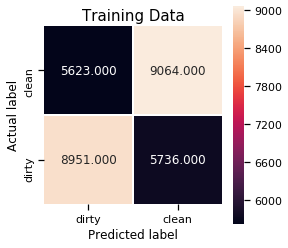

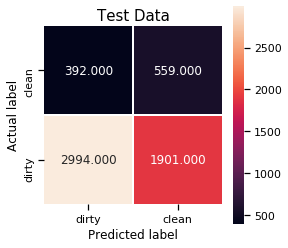

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

sns.set_context('notebook');
Outcome = ['dirty', 'clean'];

#ax = plt.subplot2grid((1,2), (0,0))

cm = metrics.confusion_matrix(y_train_res, predictions_Train);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Training Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);

#ax1 = plt.subplot2grid((1,2), (0,1))
cm1 = metrics.confusion_matrix(y_test, predictions);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm1, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Test Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);
    #plt.savefig('Confusion_Matrix.png')
plt.show();

#### Get recall and precision. Precision is most important for my question!!

In [28]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

recall_train = recall_score(y_train_res, predictions_Train)
recall_test = recall_score(y_test, predictions)

print(f'Recall of the TRAINING data is : {recall_train} ')
print(f'Recall of the TEST data is : {recall_test} ')
print('')

precision_train = precision_score(y_train_res, predictions_Train)
precision_test = precision_score(y_test, predictions)

print(f'Precision of the TRAINING data is : {precision_train} ')
print(f'Precision of the TEST data is : {precision_test} ')

Recall of the TRAINING data is : 0.632668346156465 
Recall of the TEST data is : 0.6572029442691903 

Precision of the TRAINING data is : 0.5745733366312145 
Precision of the TEST data is : 0.21663778162911612 


In [30]:
#Make probability predictions
train_prob = logisticRegr.predict_proba(x_train_res)[:,1]
test_prob = logisticRegr.predict_proba(x_test)[:,1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train_res, train_prob)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, test_prob)}')

Train ROC AUC Score: 0.611427448004946
Test ROC AUC  Score: 0.6279829092326877


#### Grid search to maximize precision

In [92]:
from sklearn.model_selection import GridSearchCV
logisticRegr2 = LogisticRegression();
grid_values = {'penalty': ['l1', 'l2'], 'C': [.001, .009, .01, .09, 1, 5, 10, 25], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']};
grid_logistic_acc = GridSearchCV(logisticRegr2, param_grid = grid_values, scoring = 'precision');
grid_logistic_acc.fit(x_train_res, y_train_res);

/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/anaconda3/env

/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The ma

KeyboardInterrupt: 

In [36]:
#Predict values based on new parameters
y_pred_test_grid = grid_logistic_acc.predict(x_test)
y_pred_train_grid = grid_logistic_acc.predict(x_train_res)

recall_train = recall_score(y_train_res, y_pred_train_grid)
recall_test = recall_score(y_test, y_pred_test_grid)

print(f'Recall of the TRAINING data is : {recall_train} ')
print(f'Recall of the TEST data is : {recall_test} ')
print('')

precision_train = precision_score(y_train_res, y_pred_train_grid)
precision_test = precision_score(y_test, y_pred_test_grid)

print(f'Precision of the TRAINING data is : {precision_train} ')
print(f'Precision of the TEST data is : {precision_test} ')

Recall of the TRAINING data is : 0.6262000408524545 
Recall of the TEST data is : 0.655099894847529 

Precision of the TRAINING data is : 0.5763975933818 
Precision of the TEST data is : 0.2195981670778992 


In [41]:
#Make probability predictions
train_prob = grid_logistic_acc.predict_proba(x_train_res)[:,1]
test_prob = grid_logistic_acc.predict_proba(x_test)[:,1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train_res, train_prob)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, test_prob)}')
print('')
from sklearn.metrics import confusion_matrix
#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_test_grid)))

Train ROC AUC Score: 0.6098077767354065
Test ROC AUC  Score: 0.631644234497529

Confusion Matrix : 
[[2681 2214]
 [ 328  623]]


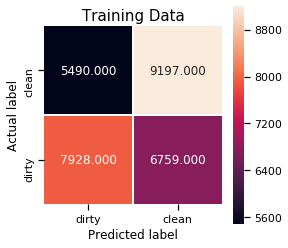

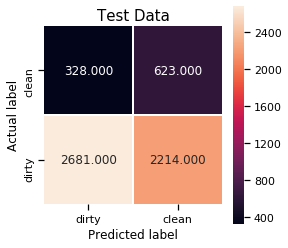

In [91]:
sns.set_context('notebook');
Outcome = ['dirty', 'clean'];
cm = metrics.confusion_matrix(y_train_res, y_pred_train_grid);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Training Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);


cm = metrics.confusion_matrix(y_test, y_pred_test_grid);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Test Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);

# Add interactions and polynomials
#### First, just interaction terms

In [131]:
from sklearn.preprocessing import PolynomialFeatures

# the default "include_bias=True" adds a feature that's constantly 1
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_inter = interaction.fit_transform(Good_x)

#### Train/Test split 75/25

In [132]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_inter, Good_y, test_size=0.25, random_state=123, shuffle = True)

In [133]:
print(f'Size of training features: {x_train.shape}')
print(f'Size of training labels: {y_train.shape}')
print(f'Size of test features: {x_test.shape}')
print(f'Size of test labels: {y_test.shape}')

Size of training features: (17535, 136)
Size of training labels: (17535,)
Size of test features: (5846, 136)
Size of test labels: (5846,)


#### Normalize values to be between 0 and 1

In [134]:
# Normalize continuous variables
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [214]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 123)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [139]:
logisticRegr_Poly = LogisticRegression();
grid_values = {'penalty': ['l1', 'l2'], 'C': [.001, .009, .01, .09, 1, 5, 10, 25], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']};
grid_logistic_poly = GridSearchCV(logisticRegr2, param_grid = grid_values, scoring = 'precision');
grid_logistic_poly.fit(x_train_res, y_train_res);

In [141]:
predictions_poly_test = grid_logistic_poly.predict(x_test)
predictions_poly_train = grid_logistic_poly.predict(x_train_res)

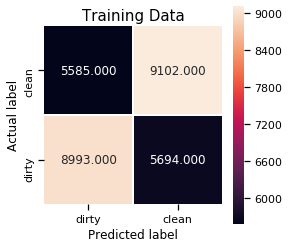

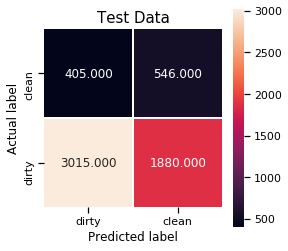

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

sns.set_context('notebook');
Outcome = ['dirty', 'clean'];
cm = metrics.confusion_matrix(y_train_res, predictions_poly_train);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Training Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);


cm = metrics.confusion_matrix(y_test, predictions_poly_test);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Test Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);
#plt.savefig('Confusion_Matrix.png')

#### Get recall and precision. Precision is most important for my question!!

In [144]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

recall_train = recall_score(y_train_res, predictions_poly_train)
recall_test = recall_score(y_test, predictions_poly_test)

print(f'Recall of the TRAINING data is : {recall_train} ')
print(f'Recall of the TEST data is : {recall_test} ')
print('')

precision_train = precision_score(y_train_res, predictions_poly_train)
precision_test = precision_score(y_test, predictions_poly_test)

print(f'Precision of the TRAINING data is : {precision_train} ')
print(f'Precision of the TEST data is : {precision_test} ')

Recall of the TRAINING data is : 0.6197317355484442 
Recall of the TEST data is : 0.5741324921135647 

Precision of the TRAINING data is : 0.6151662611516626 
Precision of the TEST data is : 0.22506183017312448 


In [146]:
#Make probability predictions
train_prob = grid_logistic_poly.predict_proba(x_train_res)[:,1]
test_prob = grid_logistic_poly.predict_proba(x_test)[:,1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train_res, train_prob)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, test_prob)}')

Train ROC AUC Score: 0.6614923438456741
Test ROC AUC  Score: 0.6315232930445774


# Try Unconstrained Decision Tree

In [147]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Good_x, Good_y, test_size=0.25, random_state=0, shuffle = True)

In [148]:
x_test.shape
y_test.shape
x_train.shape
y_train.shape

(5846, 16)

(5846,)

(17535, 16)

(17535,)

#### Normalize values to be between 0 and 1

In [149]:
# Normalize continuous variables
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [155]:
#Import Model
from sklearn.tree import DecisionTreeClassifier

#Instantiate model with 1000 decision trees
tree = DecisionTreeClassifier(random_state = 123)

In [160]:
# Create parameter space
# Create lists of parameter for Decision Tree Classifier
# Create a dictionary of all the parameter options 
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': [2,4,6,8,12],
              'min_samples_split': range(10,500,20) }


# Conduct Parameter Optmization With Pipeline
# Create a grid search object
grid_decision_tree = GridSearchCV(tree, parameters)

# Fit the grid search
grid_decision_tree.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=123,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                 

In [163]:
# View The Best Parameters
print('Best Criterion:', grid_decision_tree.best_estimator_.get_params()['criterion'])
print('Best max_depth:', grid_decision_tree.best_estimator_.get_params()['max_depth'])

Best Criterion: entropy
Best max_depth: 4


#### Generate predictions

In [166]:
predictions_DT_test = grid_decision_tree.predict(x_test)

predictions_DT_train = grid_decision_tree.predict(x_train)

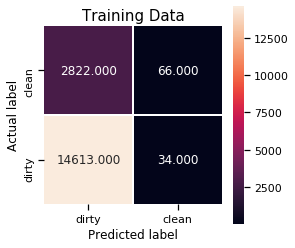

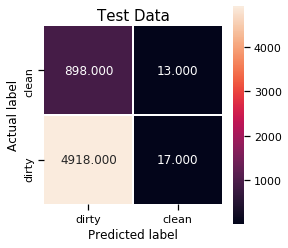

In [167]:
sns.set_context('notebook');
Outcome = ['dirty', 'clean'];
cm = metrics.confusion_matrix(y_train, predictions_DT_train);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Training Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);
#plt.savefig('Confusion_Matrix.png')


cm = metrics.confusion_matrix(y_test, predictions_DT_test);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Test Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);

In [168]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

recall_train = recall_score(y_train, predictions_DT_train)
recall_test = recall_score(y_test, predictions_DT)

print(f'Recall of the TRAINING data is : {recall_train} ')
print(f'Recall of the TEST data is : {recall_test} ')
print ('')

precision_train = precision_score(y_train, predictions_DT_train)
precision_test = precision_score(y_test, predictions_DT)

print(f'Precision of the TRAINING data is : {precision_train} ')
print(f'Precision of the TEST data is : {precision_test}')

Recall of the TRAINING data is : 0.022853185595567867 
Recall of the TEST data is : 0.24807903402854006 

Precision of the TRAINING data is : 0.66 
Precision of the TEST data is : 0.21161048689138576


In [169]:
#Make probability predictions
train_prob = grid_decision_tree.predict_proba(x_train)[:,1]
test_prob = grid_decision_tree.predict_proba(x_test)[:,1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_prob)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, test_prob)}')

Train ROC AUC Score: 0.6375890957977459
Test ROC AUC  Score: 0.6237328964797026


#### The unconstrained Decision tree has overfit the training data. Now try a short tree.

# Try short tree
#### Limit the maximum depth of the tree

In [170]:
# Limit maximum depth and train
short_tree = DecisionTreeClassifier(max_depth = 4, random_state=123)
short_tree.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [171]:
predictions_Short_train = short_tree.predict(x_train)
predictions_Short_test = short_tree.predict(x_test)

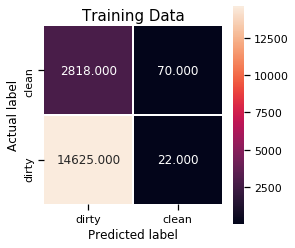

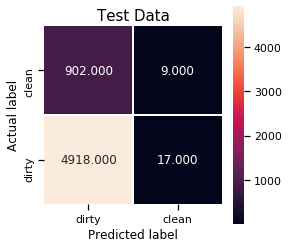

In [172]:
sns.set_context('notebook');
Outcome = ['dirty', 'clean'];
cm = metrics.confusion_matrix(y_train, predictions_Short_train);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Training Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);
#plt.savefig('Confusion_Matrix.png')


cm = metrics.confusion_matrix(y_test, predictions_Short_test);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Test Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);

In [173]:
recall_train = recall_score(y_train, predictions_Short_train)
recall_test = recall_score(y_test, predictions_Short_test)

print(f'Recall of the TRAINING data is : {recall_train} ')
print(f'Recall of the TEST data is : {recall_test} ')
print ('')

precision_train = precision_score(y_train, predictions_Short_train)
precision_test = precision_score(y_test, predictions_Short_test)

print(f'Precision of the TRAINING data is : {precision_train} ')
print(f'Precision of the TEST data is : {precision_test}')

Recall of the TRAINING data is : 0.024238227146814405 
Recall of the TEST data is : 0.009879253567508232 

Precision of the TRAINING data is : 0.7608695652173914 
Precision of the TEST data is : 0.34615384615384615


In [175]:
#Make probability predictions
train_prob = short_tree.predict_proba(x_train)[:,1]
test_prob = short_tree.predict_proba(x_test)[:,1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_prob)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, test_prob)}')

Train ROC AUC Score: 0.6262992861367053
Test ROC AUC  Score: 0.626771631650535


# Try random forest
#### First, use a random grid to find best hyperparameters

In [195]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

RandForest = RandomForestClassifier(random_state= 123)

#### Input parameter ranges for input into a random grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


In [217]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
RandForest_random = RandomizedSearchCV(estimator = RandForest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=123, n_jobs = 4)
#Fit on training data
RandForest_random.fit(x_train_res, y_train_res)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 61.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 101.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [218]:
# view the best parameters
RandForest_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [220]:
# Evaluate precision of this random model

#Make predictions on the test data
RandForest_random_predictions_test = RandForest_random.predict(x_test)
RandForest_random_predictions_train = RandForest_random.predict(x_train_res)

precision_test_rand = precision_score(y_test, RandForest_random_predictions_test)
precision_train_rand = precision_score(y_train_res, RandForest_random_predictions_train)

print(f'Precision of the training data is: {precision_train}')
print(f'Precision of the test data is: {precision_test}')

Precision of the training data is: 0.9183673469387755
Precision of the test data is: 0.45


#### Use the results from the random search to narrow down the range for each hyperparameter. Use this information for a GridSearch

In [221]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [10, 15, 20, 25],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [6, 8, 10, 12],
    'n_estimators': [1000, 1200, 1500, 2000]
}
# Create a based model
RandForest = RandomForestClassifier(random_state= 123)

# Instantiate the grid search model
RF_grid_search = GridSearchCV(estimator = RandForest, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [222]:
# Fit the grid search to the data
RF_grid_search.fit(x_train_res, y_train_res)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 99.3min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 181.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=123,
                                 

In [223]:
# Print out the best parameters 

RF_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 1500}

In [225]:
#Make predictions on the test data
RandForest_predictions = RF_grid_search.predict(x_test)
RandForest_predictions_train = RF_grid_search.predict(x_train_res)

#Get probabilities for each class
RandForest_probs_train = RF_grid_search.predict_proba(x_train_res)[:,1]
RandForest_probs_test = RF_grid_search.predict_proba(x_test)[:,1]

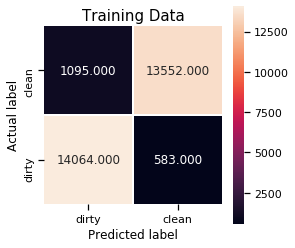

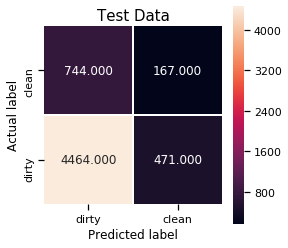

In [226]:
sns.set_context('notebook');
Outcome = ['dirty', 'clean'];
cm = metrics.confusion_matrix(y_train_res, RandForest_predictions_train);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Training Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);
#plt.savefig('Confusion_Matrix.png')


cm = metrics.confusion_matrix(y_test, RandForest_predictions);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Test Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);

In [228]:
recall_test = recall_score(y_test, RandForest_predictions);
recall_train = recall_score(y_train_res, RandForest_predictions_train);

print(f'Recall of the training data is : {recall_train}')
print(f'Recall of the test data is : {recall_test}')

Recall of the training data is : 0.925240663617123
Recall of the test data is : 0.18331503841931943


In [229]:
precision_test = precision_score(y_test, RandForest_predictions)
precision_train = precision_score(y_train_res, RandForest_predictions_train)

print(f'Precision of the training data is: {precision_train}')
print(f'Precision of the test data is: {precision_test}')

Precision of the training data is: 0.9587548638132296
Precision of the test data is: 0.2617554858934169


In [230]:
from sklearn.metrics import roc_auc_score

#Calculate roc auc
roc_value_train = roc_auc_score(y_train_res, RandForest_probs_train)
roc_value_test = roc_auc_score(y_test, RandForest_probs_test)
print(f'ROC AUC of the training data is: {roc_value_train}')
print(f'ROC AUC of the test data is: {roc_value_test}')

ROC AUC of the training data is: 0.9905199491612097
ROC AUC of the test data is: 0.6005755390882793


In [231]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(Good_x.columns),
                   'importance': RF_grid_search.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'